<a href="https://colab.research.google.com/github/raheelam98/LangGraph/blob/main/fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lang Chain and Lang Graph Fundaments

In [171]:
# install the required packages
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai

In [172]:
# API Keys
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "rm-academy"

gemini_api_key = userdata.get('GEMINI_API_KEY')

In [173]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

In [174]:
# check llm is working
result = llm.invoke("hi")
result

AIMessage(content='Hi there! How can I help you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-b12c96c0-e7fa-47bd-9e2f-56585fd7b805-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

In [175]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [176]:
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

**Tutorials**

[How-to Guides - LangGraph](https://langchain-ai.github.io/langgraph/how-tos/)


### Module 1

[Module 1 - GitHub](https://github.com/panaversity/learn-applied-generative-ai-fundamentals/tree/main/03_langchain_ecosystem/langgraph/course-notebooks/module-1)

[Q3,Q4,Q5 - Class -14: LangGraph - Six steps to create a graph : Agentic Architecture - Oct 17, 2024](https://www.youtube.com/watch?v=7U_9hCE3Prs)

**3_router.ipynb**

**`Tool calling`**: Utilizes a chat model API that handles tool schemas and messages, producing tool invocations as output.

**`ToolNode`** Usage: ToolNode, a LangChain Runnable, processes graph state (with messages) and updates state with tool call results, seamlessly integrating with LangGraph's ReAct agent or any StateGraph with MessagesState.

ToolNode: Takes a list of functions and stores them within the tool node.

When any value is stored in it, ToolNode makes it runnable, calls it to perform the functionality, and provides the response

ToolNode == Runable

```bash
from langgraph.prebuilt import ToolNode # special node for function calls
from langgraph.prebuilt import tools_condition # either call tool oe end

from langgraph.graph import MessagesState


# Build graph
builder: StateGraph = StateGraph(MessagesState)

graph_builder.add_node("tools", ToolNode([multiply]))
```

**rm note**

**`ToolNode`** is a built-in function of LangGraph. We can create our own custom function that provides a list of tools such as a search engine, Excel file operations, weather search, or database search in SQL. To integrate these tools into LangGraph, pass them into a custom `ToolNode`. We’ll build our own `BasicToolNode` and replace LangGraph’s prebuilt `ToolNode` and `tools_condition` with it, using

ToolNode(tools=[your_tool]).

**ToolNode** is essentially a node within a workflow or graph that is designated to execute a specific tool or function when called.

**ToolNode** is a LangChain Runnable that takes graph state (with a list of messages) as input and outputs state update with the result of tool calls.

**ToolNode** is just a class that helps with this execution. You pass it your list of tools, and internally it stores them as name-function pairs.

**4_agent.ipynb**

**langchain-academy tutorial**

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process


**Workflow:**. rm

Here we perform multiplication.

* First, call the tool.

* The tool's response goes to the agent/assistant/GPT.

* The agent decides what to do next: either call another tool, provide a response, or proceed to another node.


In [5]:
# Create tools for calculation
from langchain_google_genai import ChatGoogleGenerativeAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: First integer
        b: Second integer
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Add a and b

    Args:
        a: First integer
        b: Second integer
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: First integer
        b: Second integer
    """
    return a / b

# Define a list to store all the tools
tools = [add, multiply, divide]

# Bind tools with the language model
llm_with_tools = llm.bind_tools(tools)


Note to connect with data with database

def check_account_balance(sql_query) --> float

  call database

  output :- SELECT * from user

  return {Balance}

* 1 step:- call database into function use query select/delete/update -> get into variable and retrun it
*  2 step :- note we can call llm for which function call first and bind toot
* 3 step :-



In [6]:
# above code directly call dictionary
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message | Instraction in Custom GPT
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Function to create node
def assistant(state: MessagesState) -> MessagesState:
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


In [7]:
from langgraph.graph import START, StateGraph

from langgraph.prebuilt import tools_condition  # Determines routing to tools or end
from langgraph.prebuilt import ToolNode  # Special node for function calls

from IPython.display import Image, display  # Import IPython display classes
from langgraph.graph.state import CompiledStateGraph

# Initialize the graph builder
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)  # Pass assistant function to assistant node
builder.add_node("tools", ToolNode(tools))  # Pass tools to ToolNode, enabling function calls and responses
# Note: ToolNode(tools) now serves as both a generator and an action node. It can call the functions and respond accordingly.


# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")  # Start by calling the assistant node

# Define conditional edges: determine routing based on the result
# Define the condition: The assistant node either routes to tools via the tool-condition or routes to END.
builder.add_conditional_edges(
    "assistant",
    tools_condition,  # Route to tools if the latest message from assistant is a tool call
    # Route to END if the latest message from assistant is not a tool call
)

# Define edge: tools call assistant
builder.add_edge("tools", "assistant")  # After tools, call assistant again

# Compile the graph to a reactive graph
react_graph: CompiledStateGraph = builder.compile()


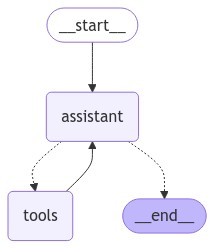

In [11]:
from IPython.display import Image, display

try:
    display(Image(react_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
messages = [HumanMessage(content="First Add 3 and 4 then multiply answer with 2 and then divide answer with 5. Dont perform division initially")]
messages = react_graph.invoke({"messages": messages})

In [13]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

First Add 3 and 4 then multiply answer with 2 and then divide answer with 5. Dont perform division initially
================================== Ai Message ==================================
Tool Calls:
  add (e5caef87-24b7-48e1-b39e-6dd0f3406507)
 Call ID: e5caef87-24b7-48e1-b39e-6dd0f3406507
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (69871740-a66e-46cb-b7d8-8e32dcda0c5e)
 Call ID: 69871740-a66e-46cb-b7d8-8e32dcda0c5e
  Args:
    a: 7.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (e324e1b9-8d3c-413d-bd7b-b434beacccdd)
 Call ID: e324e1b9-8d3c-413d-bd7b-b434b

**parallel function**

gemini_api_key = userdata.get('GEMINI_API_KEY')

In [205]:
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel

class UserModel(BaseModel):
    user_name: str

# Initialize the language model with your llm key
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=gemini_api_key)

# Define a list to store all the tools
tools = []


def add_user(user: UserModel) -> str:
    # Define the user tool as an AI function
    tools_list = [{
        "name": "add_user",
        "description": "Adds a new user to the system",
        "parameters": {
            "type": "object",
            "properties": {
                "user_name": {"type": "string"}
            },
            "required": ["user_name"]
        }
    }]

    # Bind tools with the language model
    llm_with_tools = llm.bind_tools(tools_list)

    # Create the input message for the tool
    input_messages = [
        SystemMessage(content="Add a new user to the system."),
        HumanMessage(content=f"Add user with name {user.user_name}.")
    ]

    # Call the tool with the user data
    response = llm_with_tools(input_messages)

    return response["messages"]


from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# System message | Instruction in Custom GPT
sys_msg = SystemMessage(content="You are helpful to add user name.")

# Function to create node
def assistant(state: MessagesState) -> MessagesState:
    # Prepare the user data
    user_name = state["messages"][-1].content.split(" ")[-1]
    user = UserModel(user_name=user_name)
    # Call add_user function with user data
    response = add_user(user)

    # Append AI response to messages
    new_messages = state["messages"]
    new_messages.append(AIMessage(content=response[-1]["content"]))

    return {"messages": new_messages}

from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition  # Determines routing to tools or end
from langgraph.prebuilt import ToolNode  # Special node for function calls

# Initialize the graph builder
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)  # Pass assistant function to assistant node
builder.add_node("tools", ToolNode(tools))  # Pass tools to ToolNode, enabling function calls and responses
# Note: ToolNode(tools) now serves as both a generator and an action node. It can call the functions and respond accordingly.

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")  # Start by calling the assistant node

# Define conditional edges: determine routing based on the result
# Define the condition: The assistant node either routes to tools via the tool-condition or routes to END.
builder.add_conditional_edges(
    "assistant",
    tools_condition,  # Route to tools if the latest message from assistant is a tool call
    # Route to END if the latest message from assistant is not a tool call
)

# Define edge: tools call assistant
builder.add_edge("tools", "assistant")  # After tools, call assistant again

# Compile the graph to a reactive graph
react_graph = builder.compile()

def invoke_graph(messages):
    # Wrap messages in a dictionary as expected by the state graph
    response_state = react_graph.invoke({"messages": messages})

    # Display the response
    for message in response_state["messages"]:
        if isinstance(message, AIMessage):
            print(f"AI: {message.content}")
        elif isinstance(message, HumanMessage):
            print(f"Human: {message.content}")
        elif isinstance(message, SystemMessage):
            print(f"System: {message.content}")

# Prepare messages
messages = [HumanMessage(content="Add user_name raheela")]

# Call the function to invoke the graph and handle responses
invoke_graph(messages)

TypeError: 'RunnableBinding' object is not callable